In [338]:
import math
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn import cluster
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

## Read data

In [221]:
data_dir = 'data/hw5/HMP_Dataset'
pathlist = Path(data_dir).glob('*/')
activities = {}
acc = np.empty((0,3))
labels = np.empty((0,1))
for index, path in enumerate(pathlist):
#     if(index) > 0:
#         break;
    if(path.name.startswith('.') or not path.is_dir()):
        continue
    activities[i] = path.name
    files = path.glob('*.txt')
    for j, file in enumerate(files):
        part = np.loadtxt(file)
        acc = np.vstack((acc, part))
        labels = np.vstack((labels, np.full((part.shape[0],1), path.name)))
print(acc.shape)
print(labels.shape)
# assert labels.shape[0] == 11446
assert labels.shape[0] == acc.shape[0]

(446529, 3)
(446529, 1)


In [222]:
data = np.hstack((acc, labels))
data[0]

array(['12.0', '28.0', '33.0', 'Liedown_bed'], dtype='<U32')

## Vector Quantization

In [60]:
# transform to fixed size feature vec
slice_size = 32
overlap = 0
def transform_to_samples(data, slice_size):
    n_slices = math.floor((data.shape[0])/slice_size)
    total_size = n_slices * slice_size
    slices = np.vsplit(np.vsplit(data, [total_size])[0], n_slices)
    reshaped_slices = map(lambda x: x.reshape(1, slice_size*3).flatten(), np.array(slices))
    transformed = np.array(list(reshaped_slices))
    assert transformed.shape == (len(slices), len(slices[0])*len(slices[0][1]))
    return transformed

In [61]:
transformed = transform_to_samples(acc, slice_size=slice_size)
transformed.shape

(13954, 96)

In [62]:
n_clusters = 480
k_means = cluster.KMeans(n_clusters=n_clusters)
k_means.fit(transformed)
values = k_means.cluster_centers_.squeeze()
#KFold(n_splits=2, random_state=None, shuffle=False)


In [63]:
values.shape

(480, 96)

In [120]:
def get_histogram(samples, n_K):
    labels = k_means.predict(samples)
    histogram = np.histogram(labels, bins=range(n_K+1))
#     plt.hist(histogram,density=True)
    return histogram

def get_histograms_and_labels():
    pathlist = Path(data_dir).glob('*/')
    histograms = []
    labels = []

    for path in pathlist:
        if(path.name.startswith('.') or not path.is_dir()):
            continue
        label = path.name
        files = path.glob('*.txt')
        
        for file in files:
#             if(label != 'Brush_teeth'):
#                 break
            raw = np.loadtxt(file)
            transformed = transform_to_samples(np.array(raw), slice_size=slice_size)
            histogram = get_histogram(transformed, n_clusters)
            histograms.append(histogram)
            labels.append(label)
    return np.array(histograms), np.array(labels)
        

In [121]:
historams, labels = get_histograms_and_labels()

In [128]:
historams.shape, labels.shape
assert historams[:, 0][0].shape == (n_clusters,)

In [173]:
df = pd.DataFrame(np.hstack((historams[:, 0].reshape(839,1), labels.reshape(839, 1))), columns=['histogram', 'label'])
df.head()

,histogram,label
0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Liedown_bed
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Liedown_bed
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Liedown_bed
3,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Liedown_bed
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Liedown_bed


In [266]:
def get_mean(group):
    histograms = np.array(group.histogram)
    new_histograms = np.zeros((histograms.shape[0],histograms[0].shape[0]))
    
    for i, histogram in enumerate(histograms):
        for j, count in enumerate(histogram):
            new_histograms[i][j] = count
    
    return new_histograms.mean(axis=0)
h_groups = df.groupby(['label'])
mean_histograms = h_groups.apply(get_mean)
mean_histograms

label
Brush_teeth       [0.0, 0.16666666666666666, 0.25, 0.0, 0.0, 0.0...
Climb_stairs      [0.0, 0.3431372549019608, 0.0, 0.0, 0.0, 0.0, ...
Comb_hair         [0.0, 0.5483870967741935, 0.06451612903225806,...
Descend_stairs    [0.0, 0.11904761904761904, 0.0, 0.0, 0.0476190...
Drink_glass       [0.21, 0.0, 0.0, 0.36, 0.0, 0.0, 0.06, 0.0, 0....
Eat_meat          [33.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.4, 0.0,...
Eat_soup          [0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Getup_bed         [0.019801980198019802, 0.594059405940594, 0.0,...
Liedown_bed       [0.25, 0.21428571428571427, 0.0, 0.0, 0.0, 0.0...
Pour_water        [0.1, 0.0, 0.02, 0.0, 0.0, 0.0, 0.1, 0.01, 0.0...
Sitdown_chair     [0.08, 0.44, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0...
Standup_chair     [0.10784313725490197, 0.5784313725490197, 0.0,...
Use_telephone     [0.07692307692307693, 0.0, 0.0, 0.153846153846...
Walk              [0.0, 0.91, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0...
dtype: object

In [268]:
def get_histograms_by_group(group):
    histograms = np.array(group.histogram)
    new_histograms = np.zeros((histograms.shape[0],histograms[0].shape[0]))
    
    for i, histogram in enumerate(histograms):
        for j, count in enumerate(histogram):
            new_histograms[i][j] = count
    
    return new_histograms
histograms_by_group = h_groups.apply(get_histograms_by_group)
# histograms_by_group

pandas.core.series.Series

In [257]:
report_dir = 'reports/hw5'
def plot_mean_histogram(mean_histograms_df, n_K):
    indexes = mean_histograms_df.index
    for i, histogram in enumerate(mean_histograms_df):
        fig, ax = plt.subplots()
        ax.set_title(f'mean_histograms {indexes[i]}')
        plt.bar(range(480), histogram)
        plt.savefig(f'{report_dir}/{indexes[i]}.png')

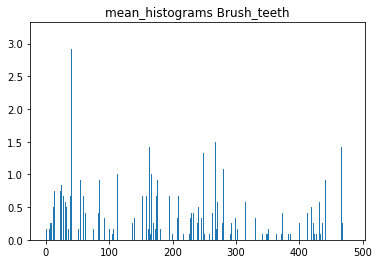

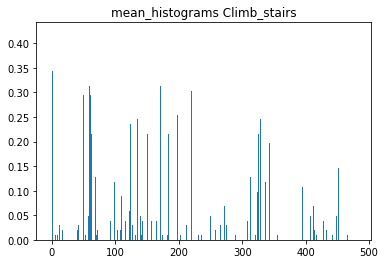

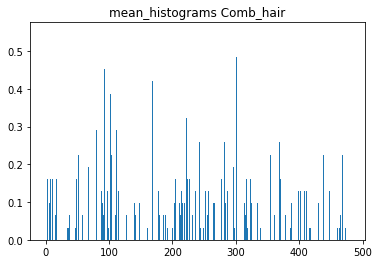

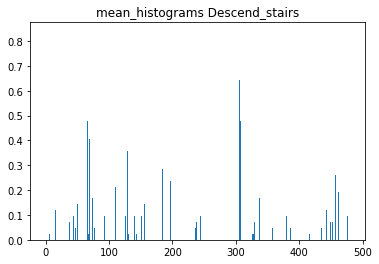

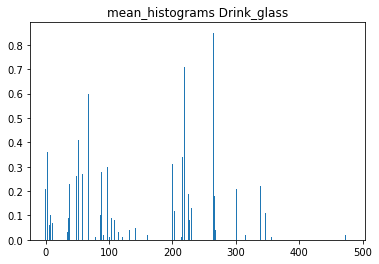

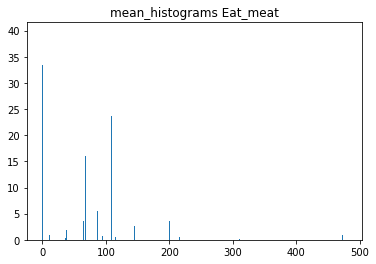

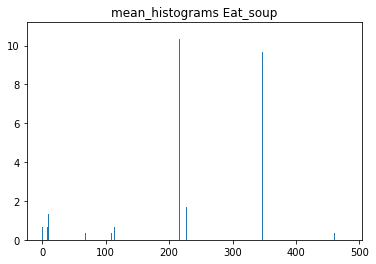

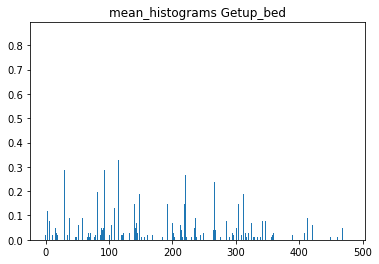

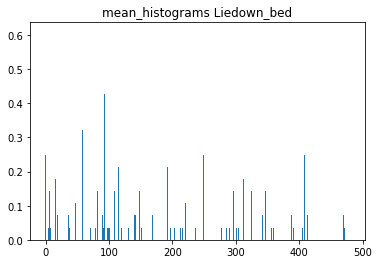

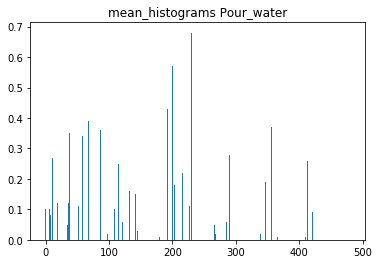

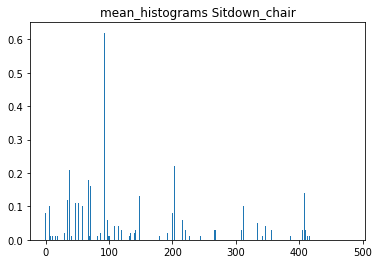

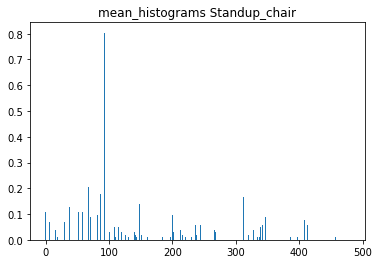

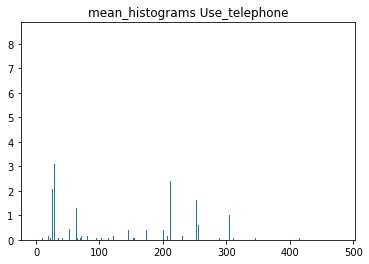

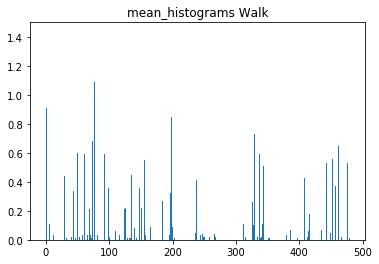

In [269]:
plot_mean_histogram(mean_histograms, n_clusters)

# Split data

In [330]:
def split_all_histograms(histograms_by_group_df, kf):
    sets = dict.fromkeys(range(3))
    for key in list(sets.keys()):
        sets[key] = [np.empty((0, 480)),np.empty((0, 480)),np.empty((0, 1)), np.empty((0, 1))]

    for label, histograms in histograms_by_group_df.items():
        X = histograms
        Y = np.full((histograms.shape[0],1), label)
        split = kf.split(X)
        for index, (train_index, test_index) in enumerate(split):
            X_each_train, X_each_test = X[train_index], X[test_index]
            Y_each_train, Y_each_test = Y[train_index], Y[test_index]

            sets[index][0] = np.vstack((sets[index][0], X_each_train))
            sets[index][1] = np.vstack((sets[index][1], X_each_test))
            sets[index][2] = np.vstack((sets[index][2], Y_each_train))
            sets[index][3] = np.vstack((sets[index][3], Y_each_test))
        
    return sets

In [331]:
kf = KFold(n_splits=3, shuffle=True)
sets = split_all_histograms(histograms_by_group, kf)

In [335]:
[X_train, X_test, Y_train, Y_test] = sets[0]
assert X_train.shape[0] + X_test.shape[0] == 839

In [336]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(554, 480)
(285, 480)
(554, 1)
(285, 1)


# Train Random Forest

In [350]:
scores = []
for i in range(3):
    [X_train, X_test, Y_train, Y_test] = sets[i]
    clf = RandomForestClassifier(n_estimators=200, max_depth=100, n_jobs=10)
    clf.fit(X_train, Y_train.squeeze())
    score = clf.score(X_test, Y_test.squeeze())
    scores.append(score)
    print(f'itr: {i}, score: {score}')
mean_accuracy = np.array(scores).mean()
print(f'average score: {mean_accuracy}')

itr: 0, score: 0.7333333333333333
itr: 1, score: 0.7805755395683454
itr: 2, score: 0.7318840579710145
average score: 0.7485976436242311
